In [40]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)
from time import time

In [41]:
###################GENERATED SIMULATED DATA################################
nsensors = 1

#In X, start sensor ids from zero.
ndims = 1 #number of dimensions besides the sensor id column

X = np.zeros([0,ndims+1]) #time,sensor
y = np.zeros([0,1])
nsamps = [100]
for sensori in range(nsensors):
    newX = np.c_[np.linspace(0,10,nsamps[sensori]),np.full(nsamps[sensori],sensori)]
    newy = newX[:,0:1]*(2+sensori*0.2)
    X = np.r_[X,newX]
    y = np.r_[y,newy]
#X = tf.Variable(X,dtype=np.float32)
#y = tf.Variable(y,dtype=np.float32)
    
##################Build inducing points, variational distributions, etc.#############
#we need a point in X, at, say sensorid=-1 for every sensor's measurement.
#this is so we can multiply the sensor value with the latent function

class Sensor():
    def K(self,X1,X2):
        return 100*np.exp(-np.sum(np.subtract(X1[:,None],X2[None,:])**2/(2*4**2),2))
    
        #assert False, "Not implemented"
    def __init__(self,num_inducing = 4):
        self.num_inducing = num_inducing
        #self.X = tf.Variable(X,dtype=tf.float32)
        #self.y = tf.Variable(y,dtype=tf.float32)
        self.Z = tf.Variable(np.linspace(-5,15,num_inducing)[:,None],dtype=tf.float32)
        
        #q(u): [things we optimise!]
        self.qmu = tf.Variable(tf.random.normal([num_inducing]))#, name='mu')        
        self.qscale = tf.Variable(tf.random.normal([num_inducing,num_inducing]))
        
        #p(u):
        self.pmu = tf.zeros([1,num_inducing])
        self.pcov = tf.Variable(self.K(self.Z,self.Z))
        self.pu = tfd.MultivariateNormalFullCovariance(self.pmu,self.pcov+np.eye(self.pcov.shape[0])*0.01)

    def get_qu(self):
        """Return the multivariate normal defined by our qmu and qscale"""
        return tfd.MultivariateNormalTriL(self.qmu,self.qscale)
    
    def compute_qf_parameters(self,X):
        """Compute mean and covariance of q(f)"""
        #q(u)
        qu = self.get_qu()
        
        #q(f)
        #TODO switch to numerically stable code & move inverse out of loop (e.g. precompute in constructor)
        invKzz = tf.linalg.inv(self.K(self.Z,self.Z)+np.eye(self.num_inducing,dtype=np.float32)*0.01)
        #print(invKzz)
        qf_mu = self.K(X,self.Z) @ invKzz @ self.qmu[:,None]
        #print(qf_mu)
        qf_cov = self.K(X,X) - self.K(X,self.Z) @ invKzz @ self.K(self.Z,X) + \
            self.K(X,self.Z)@ invKzz @(self.qscale@tf.transpose(self.qscale))@ invKzz @ self.K(self.Z,X)
        #print(qf_cov)
        return qf_mu, qf_cov
    
    def getlogpriorelbo(self):
        """Need better method name"""
        return tfd.kl_divergence(self.get_qu(),self.pu)
    
class LowCostSensor(Sensor):
    def __init__(self,num_inducing = 4):
        super().__init__(num_inducing)
        self.qmu = tf.Variable(tf.ones([num_inducing]))#, name='mu')
    #def K(self,X1,X2):
        

class ReferenceSensor(Sensor):
    pass
    #def K(self,X1,X2):
    #    return 100*np.exp(-np.sum(np.subtract(X1[:,None],X2[:,:-1][None,:])**2/(2*1**2),2))

class Latent(Sensor):
    pass
    #def K(self,X1,X2):
    #    return 100*np.exp(-np.sum(np.subtract(X1[:,None],X2[:,:-1][None,:])**2/(2*1**2),2))
    
sensors = []
#sensors.append(ReferenceSensor(10))
#sensors.append(LowCostSensor(10))
#sensors.append(LowCostSensor(10))



sensors.append(LowCostSensor(5))            
latent = Latent(5)

In [56]:
st = time()
for it in range(30):
    with tf.GradientTape() as tape:
        #
        #latent_qf_mu, latent_qf_cov = latent.compute_qf_parameters()
        for sensori, sensor in enumerate(sensors):
            elbo_loss = 0
            selforsensor = X[:,-1]==0
            Xforsensor = tf.Variable(X[selforsensor,:-1],dtype=np.float32) #maybe need to convert to TF?
            yforsensor =tf.Variable(y[selforsensor,:],dtype=np.float32)
            qf_mu, qf_cov = sensor.compute_qf_parameters(Xforsensor)
            latent_qf_mu, latent_qf_cov = latent.compute_qf_parameters(Xforsensor)
            for i in range(Xforsensor.shape[0]):
                dist_latent = tfd.Normal(latent_qf_mu[i,0],tf.sqrt(latent_qf_cov[i,i]))
                dist_f = tfd.Normal(qf_mu[i,0],tf.sqrt(qf_cov[i,i]))
                f = dist_f.sample(10000)
                lat = dist_latent.sample(10000)
                #contribution of ELL
                elbo_loss-=tf.math.reduce_mean(tfd.Normal((1+f)*lat,1.0).log_prob(yforsensor[i]))
                #contribution of prior
            #print(elbo_loss)
            elbo_loss += sensor.getlogpriorelbo()
        #elbo_loss = -elbo_loss
        elbo_loss += latent.getlogpriorelbo()
    gradients = tape.gradient(elbo_loss, [sensors[0].qmu, sensors[0].qscale, latent.qmu, latent.qscale])
    optimizer.apply_gradients(zip(gradients, [sensors[0].qmu, sensors[0].qscale, latent.qmu, latent.qscale]))
    if it%5 == 0: print("%d %0.2f %0.4f %0.0f" % (it,time()-st,(time()-st)/(it+1),elbo_loss.numpy()))#,qf_mu[:,0].numpy(),mu.numpy())
    #print(sensors[0].qmu.numpy())

0 0.81 0.8097 6854
5 4.35 0.7245 4494
10 7.81 0.7103 3362
15 11.21 0.7005 2919
20 14.94 0.7113 2516
25 18.37 0.7066 2379


In [57]:
sensors[0].qmu.numpy()

array([-0.258, -1.333,  1.452,  2.897,  4.309], dtype=float32)

In [58]:
latent.qmu.numpy()

array([-3.99 , -0.738,  2.74 ,  4.356,  3.99 ], dtype=float32)

In [59]:
latent.qmu.numpy() * sensors[0].qmu.numpy()

array([ 1.03 ,  0.985,  3.979, 12.621, 17.192], dtype=float32)

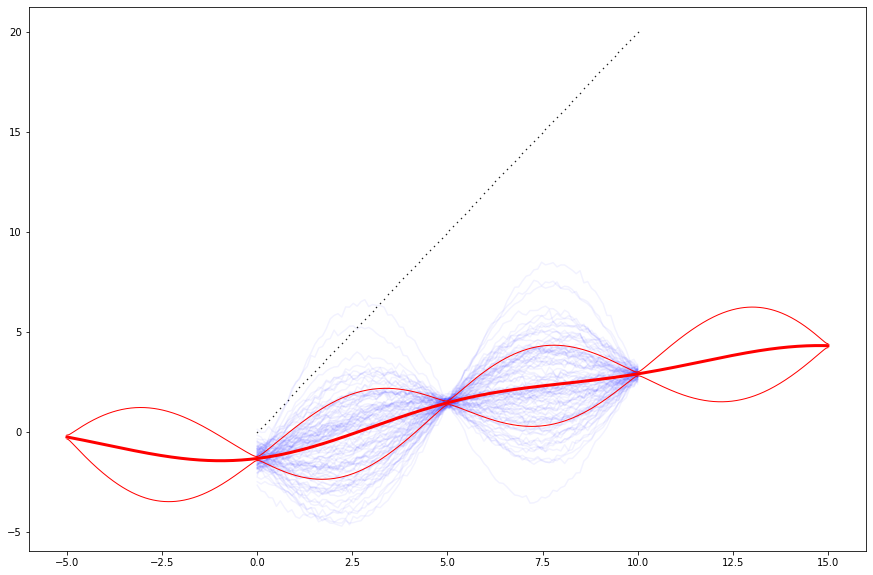

In [60]:
plt.figure(figsize=[15,10])
sensor = sensors[0]
selforsensor = X[:,-1]==0
Xforsensor = tf.Variable(X[selforsensor,:-1],dtype=np.float32) #maybe need to convert to TF?
yforsensor =tf.Variable(y[selforsensor,:],dtype=np.float32)

qmu, qcov = sensor.compute_qf_parameters(Xforsensor)
qf = tfd.MultivariateNormalFullCovariance(qmu[:,0],qcov+np.eye(qcov.shape[0])*0.01)
samps = qf.sample([100]).numpy()
plt.plot(Xforsensor.numpy(),yforsensor.numpy(),'.k',markersize=1)
plt.plot(Xforsensor.numpy()[:,0],samps.T,'b-',alpha=0.05);
Xstar = np.linspace(-5,15,1000)[:,None]

invKzz = tf.linalg.inv(sensor.K(sensor.Z,sensor.Z)+np.eye(sensor.num_inducing,dtype=np.float32)*0.01)
mean = (sensor.K(Xstar,sensor.Z) @ invKzz @ sensor.qmu.numpy()[:,None]).numpy()[:,0]
cov = sensor.K(Xstar,Xstar) - sensor.K(Xstar,sensor.Z) @ invKzz @ sensor.K(sensor.Z,Xstar)
stds = np.sqrt(np.diag(cov))

plt.plot(Xstar,mean,'r-',lw=3);
plt.plot(Xstar,mean+stds,'r-',lw=1);
plt.plot(Xstar,mean-stds,'r-',lw=1);